In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import pdb

import sys
import os

#########################
# Experiment parameters #
#########################
from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


sys.path.append('../third_party')
sys.path.append('../methods')
from methods_experiment import oc, bc, clra

## Data generation

In [2]:
from models import ToyModel

random_state = 2021

p = 50        # Number of features
a = 3         # Signal amplitude

model = ToyModel(p, a, random_state=random_state)

n = 2000      # Number of observations
purity = 0.9  # Proportion of inliers

X, Y = model.sample(n, purity=purity)
X_test, Y_test = model.sample(n, purity=purity)

print("Number of inliers in training/calibration data: {}.".format(np.sum(Y==0)))
print("Number of outliers in training/calibration data: {}.".format(np.sum(Y==1)))

print("Number of inliers in test data: {}.".format(np.sum(Y_test==0)))
print("Number of outliers in test data: {}.".format(np.sum(Y_test==1)))

Number of inliers in training/calibration data: 1800.
Number of outliers in training/calibration data: 200.
Number of inliers in test data: 1800.
Number of outliers in test data: 200.


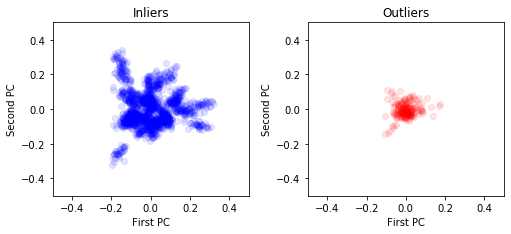

In [3]:
## Perform nonlinear PCA on an independent set of clean data
from sklearn.decomposition import KernelPCA

X_clean, _ = model.sample(n, purity=1)

pca = KernelPCA(kernel="rbf", n_components=2, gamma=0.01)
pca.fit(X_clean)

## Apply the nonlinear PCA separately to the inliers and outliers
X_in = X[Y==0]
pcs_in = pca.transform(X_in)

X_out = X[Y==1]
pcs_out = pca.transform(X_out)

## Plot the PCA results
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].scatter(pcs_in[:,0], pcs_in[:,1], alpha=0.1, color="blue")
axs[1].scatter(pcs_out[:,0], pcs_out[:,1], alpha=0.1, color="red")  
axs[0].set_xlim(-0.5,0.5)
axs[1].set_xlim(-0.5,0.5)
axs[0].set_ylim(-0.5,0.5)
axs[1].set_ylim(-0.5,0.5)
axs[0].set_xlabel("First PC")
axs[0].set_ylabel("Second PC")
axs[1].set_xlabel("First PC")
axs[1].set_ylabel("Second PC")
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
plt.show()

## Conformal p-values via one-class classification

In [4]:
# Choose a one-class classifier algorithm
method_oneclass = "IForest"

# Initialize the one-class classifier with desired hyper-parameters
if method_oneclass == "SVM":
    bbox_occ = svm.OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
if method_oneclass == "IForest":
    contamination = 0.001
    contamination = min(max(contamination,0.004),0.1)
    bbox_occ = IsolationForest(random_state=random_state, contamination=contamination)
if method_oneclass == "Neighbors":
    contamination = 0.001
    contamination = min(max(contamination,0.004),0.1)
    bbox_occ = LocalOutlierFactor(novelty=True, contamination=contamination)

In [5]:
from methods import OneClassConformal

# Extract the inliers from the data
X_in = X[Y==0]

# Compute the p-values
method_oneclass = OneClassConformal(X_in, bbox_occ, calib_size=0.5)
pvals_oneclass = method_oneclass.compute_pvalues(X_test)

Fitting the black-box model on 900 data points... done.
Calculating conformity scores for 900 data points... done.
Calculating conformity scores for 2000 test points... done.


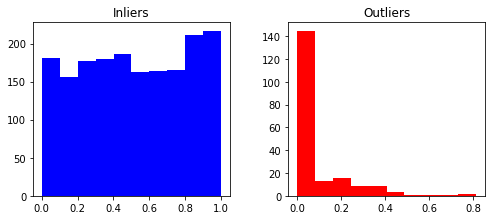

In [6]:
## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
plt.show()